# Librerías

In [ ]:
from sklearn.neighbors import kneighbors_graph
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import (calinski_harabasz_score, davies_bouldin_score,
                             silhouette_score, normalized_mutual_info_score, adjusted_rand_score)
from sklearn import metrics
from tqdm import tqdm
import networkx as nx
import pandas as pd
import scanpy as sc
import numpy as np
import h5py 

In [ ]:
def normalize(adata, filter_min_counts=True, size_factors=True, normalize_input=True, logtrans_input=True):
    if filter_min_counts:
        sc.pp.filter_genes(adata, min_counts=1)
        sc.pp.filter_cells(adata, min_counts=1)

    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    return adata

In [ ]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    y_pred = y_pred.astype(np.int64)
    
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

# Lectura de datos

In [ ]:
with h5py.File('../../data/HumanLiver_counts_top5000.h5') as file:
    X = np.array(file['X'])
    y = np.array(file['Y'])

adata = sc.AnnData(X)
adata.obs['Group'] = y

print(f'Dimensiones: {adata.X.shape}')

Dimensiones: (8444, 4999)


# Procesamiento

In [ ]:
adata = normalize(adata, size_factors=True, normalize_input=True, logtrans_input=True)

# Clusterización

In [141]:
def clustering(adata, N, resolution, correlation_function): 
    knn_graph = kneighbors_graph(adata.X, n_neighbors = N)

    for i,j in zip(knn_graph.nonzero()[0], knn_graph.nonzero()[1]):
        # Seleccionamos las células 
        cell_i, cell_j = X[i,:], X[j,:]

        # Calculamos la correlación
        correlacion = correlation_function(cell_i, cell_j).statistic
        knn_graph[i,j] = correlacion
    
    # Creación del grafo
    knn_graph = nx.from_scipy_sparse_array(knn_graph)
    communities = nx.community.louvain_communities(knn_graph, seed=123, resolution = resolution)

    # Predicción
    y_pred = np.zeros(len(knn_graph.nodes))

    for c in range(len(communities)):
        com_c = communities[c]
        for i in com_c:
            y_pred[i] = c

    return y_pred

In [142]:
def cluster_metrics(X, y, y_pred):
    # Supervised
    acc = np.round(cluster_acc(y, y_pred), 5)
    nmi = np.round(normalized_mutual_info_score(y, y_pred), 5)
    ari = np.round(adjusted_rand_score(y, y_pred), 5)
    
    # Unsupervised
    chs = np.round(calinski_harabasz_score(X, y_pred), 5)
    dbs = np.round(davies_bouldin_score(X, y_pred), 5)
    ss = np.round(silhouette_score(X, y_pred), 5)

    metrics = {'acc': acc, 'nmi': nmi, 'ari': ari,
               'chs': chs, 'dbs': dbs, 'ss': ss}
    
    return metrics

# Búsqueda de hiperparámetros

In [143]:
params = {
    'N': [5+i*2 for i in range(10)],
    'resolution': [0.1*i for i in range(1,11)], 
    'correlation_function': [pearsonr]
}
preds = {}

results = pd.DataFrame(columns = ['acc', 'nmi', 'ari', 'chs', 'dbs', 'ss'])

for N in tqdm(params['N']):
    for r in params['resolution']:
        for i, cf in enumerate(params['correlation_function']):
            print(N, r, i)
            y_pred = clustering(adata, N = N, resolution = r, correlation_function = cf)
            results.loc[str((N,r,i))] = cluster_metrics(adata.X, y, y_pred)
            preds[str((N,r,i))] = y_pred
results

  0%|          | 0/10 [00:00<?, ?it/s]

5 0.1 0
5 0.2 0
5 0.30000000000000004 0
5 0.4 0
5 0.5 0
5 0.6000000000000001 0
5 0.7000000000000001 0
5 0.8 0
5 0.9 0
5 1.0 0


 10%|█         | 1/10 [04:24<39:39, 264.34s/it]

7 0.1 0
7 0.2 0
7 0.30000000000000004 0
7 0.4 0
7 0.5 0
7 0.6000000000000001 0
7 0.7000000000000001 0
7 0.8 0
7 0.9 0
7 1.0 0


 20%|██        | 2/10 [09:40<39:19, 294.91s/it]

9 0.1 0
9 0.2 0
9 0.30000000000000004 0
9 0.4 0
9 0.5 0
9 0.6000000000000001 0
9 0.7000000000000001 0
9 0.8 0
9 0.9 0
9 1.0 0


 30%|███       | 3/10 [15:44<38:04, 326.31s/it]

11 0.1 0
11 0.2 0
11 0.30000000000000004 0
11 0.4 0
11 0.5 0
11 0.6000000000000001 0
11 0.7000000000000001 0
11 0.8 0
11 0.9 0
11 1.0 0


 40%|████      | 4/10 [22:41<36:12, 362.12s/it]

13 0.1 0
13 0.2 0
13 0.30000000000000004 0
13 0.4 0
13 0.5 0
13 0.6000000000000001 0
13 0.7000000000000001 0
13 0.8 0
13 0.9 0
13 1.0 0


 50%|█████     | 5/10 [30:22<33:08, 397.72s/it]

15 0.1 0
15 0.2 0
15 0.30000000000000004 0
15 0.4 0
15 0.5 0
15 0.6000000000000001 0
15 0.7000000000000001 0
15 0.8 0
15 0.9 0
15 1.0 0


 60%|██████    | 6/10 [38:55<29:08, 437.01s/it]

17 0.1 0
17 0.2 0
17 0.30000000000000004 0
17 0.4 0
17 0.5 0
17 0.6000000000000001 0
17 0.7000000000000001 0
17 0.8 0
17 0.9 0
17 1.0 0


 70%|███████   | 7/10 [48:23<23:59, 479.97s/it]

19 0.1 0
19 0.2 0
19 0.30000000000000004 0
19 0.4 0
19 0.5 0
19 0.6000000000000001 0
19 0.7000000000000001 0
19 0.8 0
19 0.9 0
19 1.0 0


 80%|████████  | 8/10 [58:45<17:30, 525.11s/it]

21 0.1 0
21 0.2 0
21 0.30000000000000004 0
21 0.4 0
21 0.5 0
21 0.6000000000000001 0
21 0.7000000000000001 0
21 0.8 0
21 0.9 0
21 1.0 0


 90%|█████████ | 9/10 [1:10:05<09:33, 573.43s/it]

23 0.1 0
23 0.2 0
23 0.30000000000000004 0
23 0.4 0
23 0.5 0
23 0.6000000000000001 0
23 0.7000000000000001 0
23 0.8 0
23 0.9 0
23 1.0 0


100%|██████████| 10/10 [1:22:55<00:00, 497.51s/it]


,acc,nmi,ari,chs,dbs,ss
"(5, 0.1, 0)",0.61357,0.42094,0.24458,64.85919,3.81025,0.03570
"(5, 0.2, 0)",0.61416,0.42073,0.24596,54.44940,3.41049,0.03596
"(5, 0.30000000000000004, 0)",0.61819,0.42873,0.25221,50.67924,3.07406,0.03831
"(5, 0.4, 0)",0.61997,0.44051,0.26054,53.14614,3.70203,0.04335
"(5, 0.5, 0)",0.62174,0.43788,0.28254,47.28637,3.85069,0.05714
...,...,...,...,...,...,...
"(23, 0.6000000000000001, 0)",0.61499,0.48414,0.34795,79.91234,5.07180,-0.00562
"(23, 0.7000000000000001, 0)",0.61890,0.49237,0.35535,76.88869,4.73447,-0.00364
"(23, 0.8, 0)",0.61795,0.51106,0.34541,79.06327,4.65826,-0.01176
"(23, 0.9, 0)",0.61807,0.51341,0.34800,78.79798,4.81140,-0.01139


<Axes: >

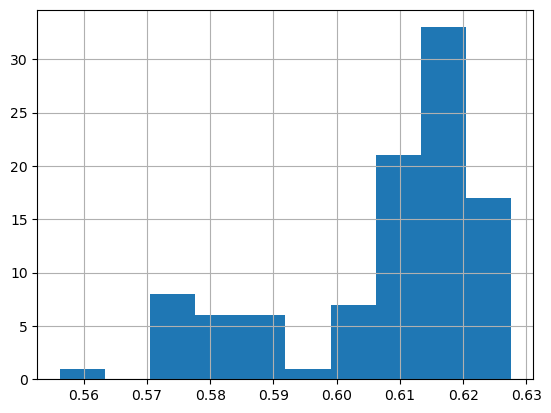

In [146]:
results.acc.hist()

In [144]:
import pickle
with open('results.pickle', 'wb') as file:
    pickle.dump( 
        file=file, obj = results)

# Prueba con los datos chiquitos

In [ ]:
X = pd.read_csv('../../results/HumanLiver_counts_top5000/Z.csv')
X